## Analyze the generated tweets 

- Days : 15
- llm : dolphin-llama3
- Agent : 20
- Posts : 189
- Like : 23

In [191]:
import sqlite3
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [192]:
# load the data 
conn = sqlite3.connect('../YClient/experiments/MusicJazzRock-15days.db')
c = conn.cursor()

In [193]:
# for each table, get the columns
tables = ['sqlite_sequence', 'hashtags', 'post_hashtags', 'mentions', 'emotions', 'post_emotions', 'rounds', 'follow', 'reactions', 'websites', 'articles', 'post', 'recommendations', 'voting', 'user_interest', 'interests', 'post_topics', 'user_mgmt']
for table in tables:
    print(table)
    c.execute("PRAGMA table_info(" + table +")")
    print(c.fetchall())

sqlite_sequence
[(0, 'name', '', 0, None, 0), (1, 'seq', '', 0, None, 0)]
hashtags
[(0, 'hashtag', 'TEXT', 1, None, 0), (1, 'id', 'INTEGER', 0, None, 1)]
post_hashtags
[(0, 'post_id', 'INTEGER', 0, None, 0), (1, 'hashtag_id', 'INTEGER', 0, None, 0), (2, 'id', 'INTEGER', 1, None, 1)]
mentions
[(0, 'id', 'INTEGER', 0, None, 1), (1, 'user_id', 'INT', 0, None, 0), (2, 'post_id', 'INTEGER', 0, None, 0), (3, 'round', 'INTEGER', 0, None, 0), (4, 'answered', 'INTEGER', 0, '0', 0)]
emotions
[(0, 'id', 'INTEGER', 1, None, 1), (1, 'emotion', 'TEXT', 1, None, 0)]
post_emotions
[(0, 'id', 'INTEGER', 0, None, 1), (1, 'post_id', 'INTEGER', 0, None, 0), (2, 'emotion_id', 'INTEGER', 0, None, 0)]
rounds
[(0, 'id', 'INTEGER', 1, None, 1), (1, 'day', 'INTEGER', 0, None, 0), (2, 'hour', 'INTEGER', 0, None, 0)]
follow
[(0, 'user_id', 'INTEGER', 1, None, 0), (1, 'follower_id', 'INTEGER', 1, None, 0), (2, 'id', 'INTEGER', 1, None, 1), (3, 'action', 'TEXT', 0, None, 0), (4, 'round', 'INTEGER', 0, None, 0)]
rea

In [206]:
query = """
SELECT 
    u.id AS user_id,
    u.username,
    r.type AS reaction_type,
    GROUP_CONCAT(DISTINCT pt_topic.topic_id) AS user_post_topics,
    GROUP_CONCAT(DISTINCT ct_topic.topic_id) AS user_comment_topics,
    GROUP_CONCAT(DISTINCT et_topic.topic_id) AS emotion_topics,
    GROUP_CONCAT(DISTINCT i.interest) AS user_interests
FROM 
    user_mgmt u

-- 1. Topics des posts de l'utilisateur
LEFT JOIN post p ON u.id = p.user_id
LEFT JOIN post_topics pt_topic ON p.id = pt_topic.post_id

-- 2. Topics des commentaires (post.comment_to != -1 indique un commentaire)
LEFT JOIN post c ON u.id = c.user_id AND c.comment_to != -1
LEFT JOIN post_topics ct_topic ON c.id = ct_topic.post_id

-- 3. Topics des posts/commentaires aimés (émotions)
LEFT JOIN reactions r ON u.id = r.user_id
LEFT JOIN post_topics et_topic ON r.post_id = et_topic.post_id

-- 4. Intérêts de l'utilisateur
LEFT JOIN user_interest ui ON u.id = ui.user_id
LEFT JOIN interests i ON ui.interest_id = i.iid

GROUP BY u.id, u.username;

"""

df = pd.read_sql_query(query, conn)
df


,user_id,username,reaction_type,user_post_topics,user_comment_topics,emotion_topics,user_interests
0,14,AmandaCarter,None,"1,2,3",None,None,"music,rock,jazz"
1,11,AmyWest,like,3,None,3,"music,rock,jazz"
2,12,ArianaDay,like,"2,1,3",None,"1,3","music,rock,jazz"
3,4,BenjaminPadilla,None,"1,3",None,None,"music,rock,jazz"
4,10,CollinPorter,like,"2,3",None,"3,2","rock,jazz"
5,8,DanielleWallace,like,"2,3,1",None,"1,2","music,rock,jazz"
6,3,GinaCarpenter,None,None,None,None,"music,rock,jazz"
7,16,JanetKing,like,"1,2,3",None,None,"music,rock,jazz"
8,15,JonathanAnthony,None,"1,3,2",None,None,"music,rock,jazz"
9,5,KevinAdams,dislike,"1,3",None,2,"music,rock,jazz"


In [194]:
query = """
SELECT 
    u.username AS user_id,
    i.interest AS user_interest,
    t.interest AS post_topic,
    r.type AS reaction_type,
    COUNT(DISTINCT r.id) AS total_reactions
FROM 
    reactions r
JOIN 
    post_topics pt ON r.post_id = pt.post_id
JOIN 
    interests t ON pt.topic_id = t.iid
JOIN 
    user_interest ui ON u.id = ui.user_id
JOIN 
    interests i ON ui.interest_id = i.iid
JOIN 
    user_mgmt u ON r.user_id = u.id
WHERE 
    i.interest = t.interest -- Intérêt utilisateur correspond au sujet du post
    AND (r.type = 'like' OR r.type = 'dislike')
GROUP BY 
    u.id, i.interest, t.interest, r.type
ORDER BY 
    u.id, total_reactions DESC;
"""

df = pd.read_sql_query(query, conn)
df


,user_id,user_interest,post_topic,reaction_type,total_reactions
0,KevinAdams,rock,rock,dislike,1
1,DanielleWallace,music,music,like,1
2,DanielleWallace,rock,rock,like,1
3,CollinPorter,jazz,jazz,like,1
4,CollinPorter,rock,rock,dislike,1
5,AmyWest,jazz,jazz,like,1
6,ArianaDay,jazz,jazz,like,1
7,ArianaDay,music,music,like,1
8,RickScott,jazz,jazz,like,2
9,RickScott,music,music,like,1


En gros KevinAdams et CollinPorter ne sont pas honnetes 

<h4> Let's clean the data !


In [195]:
# clean the posts 
# remove the  "###END###" "##CONVERSATION END##" from tweet of each post
# recuperer d'abord les posts
query = """
SELECT
    p.id AS post_id,
    p.tweet AS tweet
FROM
    post p
"""
posts_df = pd.read_sql_query(query, conn)
for index, row in posts_df.iterrows():
    print(row['tweet'])
    print('---')



care. 

#RockScience #SelfCare
---
versed in the genre? Thanks for sparking such engaging conversations!
---


I'm really loving classic rock songs lately and can't resist singing along to them aloud in karaoke bars, regardless of others staring at me with raised eyebrows! Nothing compares to the great electric guitar solo & deep drums beats, which always keep my energetic feet tapping and take me away.#RockAndRollAlways will be a part of the soundtrack of our life!
---
###)###END###
---
 stay curious, careless & compassionate!🌈
#ImMichaelPope #BeIndependent
---
I love how Rock music has evolved over time! The innovative sounds that burst from this genre have been a steady companion through various peaks and valleys.Who else is enjoying the latest Rock tunes? #RockMusicLovers 🎶🙌
---
 ###)###END###
##CONVERSATION END##
---
 adapt!
---
Hey there, fellow jazz and rock lovers! Just finished listening to Dave Brubeck's 'Take Five', feeling those smooth notes hit my nerve endings just right 

In [196]:

# remove the "###END###" "##CONVERSATION END##" from tweet of each post
posts_df['tweet'] = posts_df['tweet'].str.replace('###END###', '')
posts_df['tweet'] = posts_df['tweet'].str.replace('##CONVERSATION END##', '')
for index, row in posts_df.iterrows():
    print(row['tweet'])
    print('---')


care. 

#RockScience #SelfCare
---
versed in the genre? Thanks for sparking such engaging conversations!
---


I'm really loving classic rock songs lately and can't resist singing along to them aloud in karaoke bars, regardless of others staring at me with raised eyebrows! Nothing compares to the great electric guitar solo & deep drums beats, which always keep my energetic feet tapping and take me away.#RockAndRollAlways will be a part of the soundtrack of our life!
---
###)
---
 stay curious, careless & compassionate!🌈
#ImMichaelPope #BeIndependent
---
I love how Rock music has evolved over time! The innovative sounds that burst from this genre have been a steady companion through various peaks and valleys.Who else is enjoying the latest Rock tunes? #RockMusicLovers 🎶🙌
---
 ###)

---
 adapt!
---
Hey there, fellow jazz and rock lovers! Just finished listening to Dave Brubeck's 'Take Five', feeling those smooth notes hit my nerve endings just right 💙 #musiclover # jazzaficionado #rockan

On remarque des publications sur l'environnement. Cependant, en général, les publications sont cohérentes et restent centrées sur le sujet de la musique jazz/rock

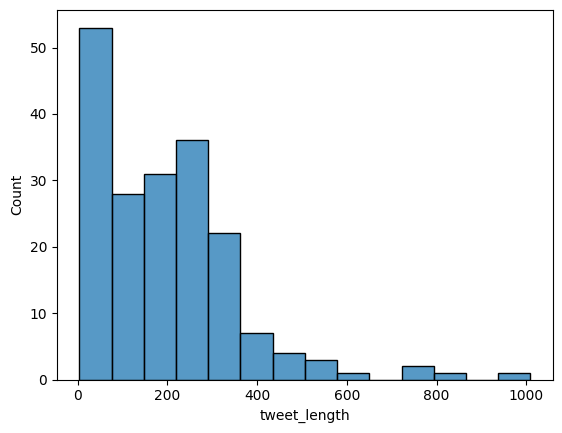

In [197]:
# plot the length of the tweets
posts_df['tweet_length'] = posts_df['tweet'].apply(len)
sns.histplot(posts_df['tweet_length'])
plt.show()

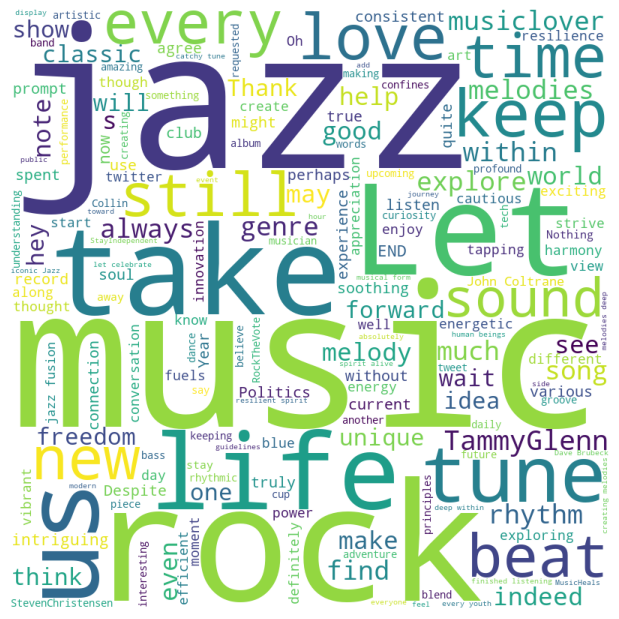

In [198]:
# cloud of words for the tweets
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(posts_df['tweet']))
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

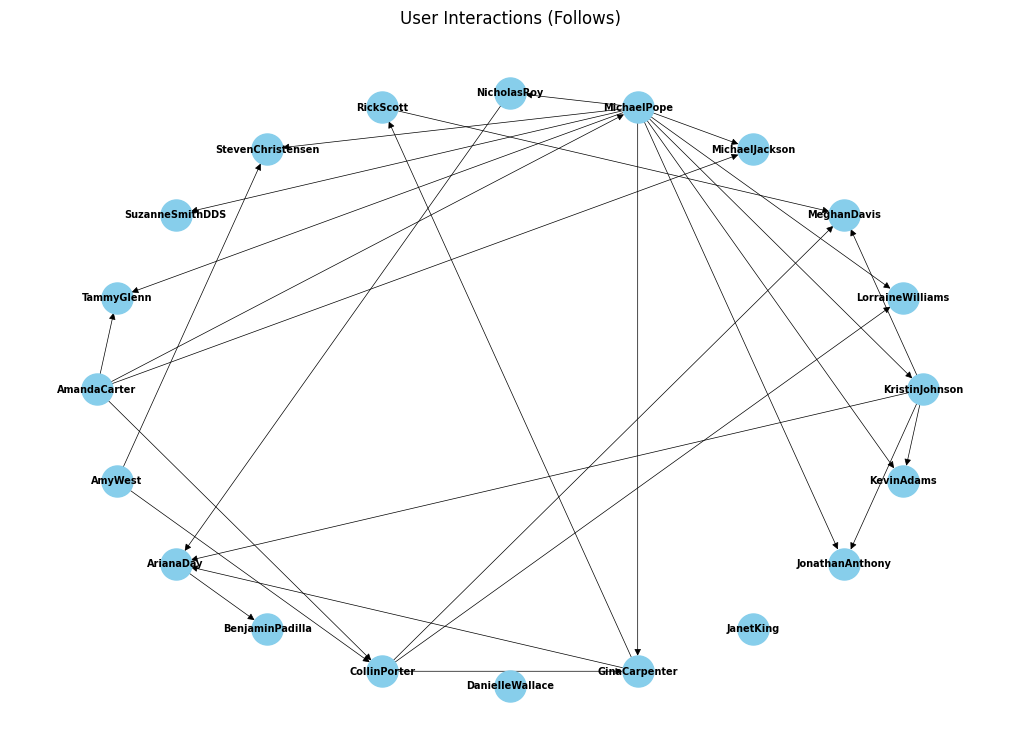

In [199]:
# Fetch follow interactions
follow_query = "SELECT follower_id, user_id FROM follow"
follow_df = pd.read_sql_query(follow_query, conn)

mention_query = "SELECT user_id AS mentioner_id, post_id AS mentioned_id FROM mentions"
mention_df = pd.read_sql_query(mention_query, conn)

users_query = "SELECT id, username FROM user_mgmt"
users_df = pd.read_sql_query(users_query, conn)

user_name_map = dict(zip(users_df['id'], users_df['username']))

# Initialize directed graph
G = nx.DiGraph()

# Add all users as nodes 
for user_id, username in user_name_map.items():
    G.add_node(user_id, label=username)

# Add follow interactions as edges
for _, row in follow_df.iterrows():
    G.add_edge(row['follower_id'], row['user_id'], type='follow')



# Plot the graph
plt.figure(figsize=(10, 7))
pos = nx.shell_layout(G)

labels = {node: user_name_map.get(node, node) for node in G.nodes()}

nx.draw(
    G, pos, with_labels=True, labels=labels, node_size=500, node_color="skyblue", font_size=7, font_weight="bold", edge_color="black", width=0.5
)

edge_labels = nx.get_edge_attributes(G, 'type')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("User Interactions (Follows)")
plt.show()
#nx.clustering(G)



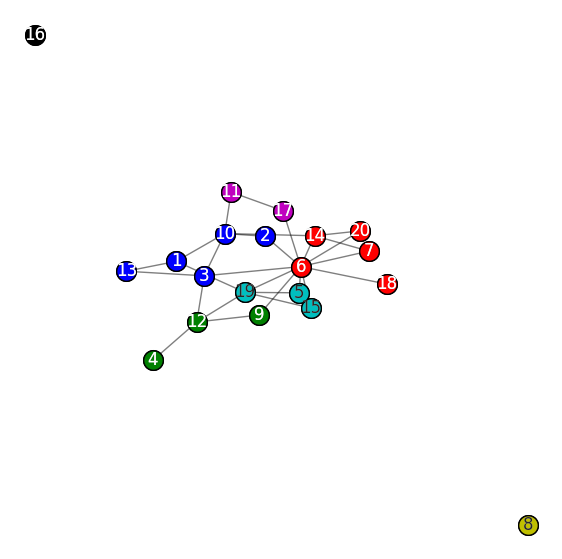

In [200]:
import cdlib
import networkx as nx
from cdlib import algorithms, viz

# Convert the graph to networkx format
G_nx = nx.Graph(G)

# Apply the Louvain algorithm
louvain_communities = algorithms.louvain(G_nx)

# Plot the network clusters
viz.plot_network_clusters(G_nx, louvain_communities, figsize=(7, 7), plot_labels=True)




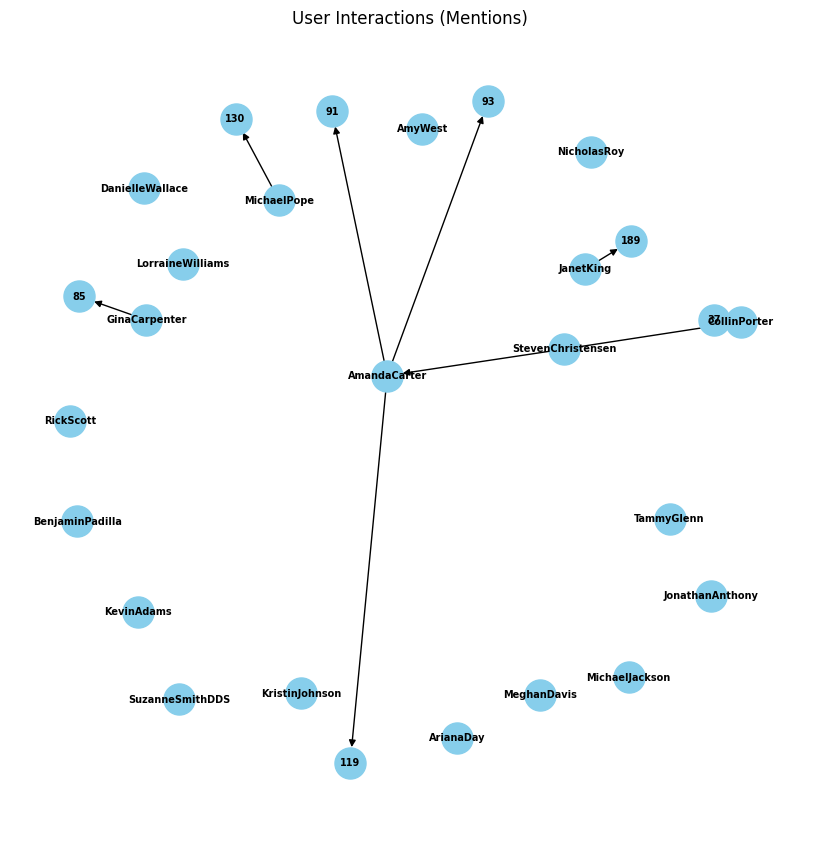

In [201]:
# Fetch follow interactions
follow_query = "SELECT follower_id, user_id FROM follow"
follow_df = pd.read_sql_query(follow_query, conn)

mention_query = "SELECT user_id AS mentioner_id, post_id AS mentioned_id FROM mentions"
mention_df = pd.read_sql_query(mention_query, conn)

users_query = "SELECT id, username FROM user_mgmt"
users_df = pd.read_sql_query(users_query, conn)

user_name_map = dict(zip(users_df['id'], users_df['username']))

# Initialize directed graph
G = nx.DiGraph()

# Add all users as nodes 
for user_id, username in user_name_map.items():
    G.add_node(user_id, label=username)


# Add mention interactions as edges
if not mention_df.empty:
    for _, row in mention_df.iterrows():
        G.add_edge(row['mentioner_id'], row['mentioned_id'], type='mention')

# Plot the graph
plt.figure(figsize=(8, 8))
  
#  forceatlas2 
pos = nx.rescale_layout_dict(nx.spring_layout(G), scale=1)

labels = {node: user_name_map.get(node, node) for node in G.nodes()}

nx.draw(
    G, pos, with_labels=True, labels=labels, node_size=500, node_color="skyblue", font_size=7, font_weight="bold"
)

edge_labels = nx.get_edge_attributes(G, 'type')

plt.title("User Interactions (Mentions)")
plt.show()


In [202]:
query = """
SELECT
    p.id AS post_id,
    p.round AS post_creation_round,
    'creation' AS event_type,
    p.round AS event_time,
    NULL AS comment_post_id,
    NULL AS reaction_user_id,
    NULL AS reaction_type,
    NULL AS mention_user_id
FROM post p
UNION
SELECT
    p.id AS post_id,
    p.round AS post_creation_round,
    'comment' AS event_type,
    c.round AS event_time,
    c.id AS comment_post_id,
    NULL AS reaction_user_id,
    NULL AS reaction_type,
    NULL AS mention_user_id
FROM post p
LEFT JOIN post c ON c.comment_to = p.id
UNION
SELECT
    p.id AS post_id,
    p.round AS post_creation_round,
    'reaction' AS event_type,
    r.round AS event_time,
    r.post_id AS comment_post_id,
    r.user_id AS reaction_user_id,
    r.type AS reaction_type,
    NULL AS mention_user_id
FROM post p
LEFT JOIN reactions r ON r.post_id = p.id
UNION
SELECT
    p.id AS post_id,
    p.round AS post_creation_round,
    'mention' AS event_type,
    m.round AS event_time,
    m.post_id AS comment_post_id,
    NULL AS reaction_user_id,
    NULL AS reaction_type,
    m.user_id AS mention_user_id
FROM post p
LEFT JOIN mentions m ON m.post_id = p.id
ORDER BY post_id, event_time;

"""

# Execute the query and fetch the results into a DataFrame
post_evolution_df = pd.read_sql_query(query, conn)

# save the dataframe to a csv file
post_evolution_df.to_csv("post_evolution.csv", index=False)

# Display the result
post_evolution_df



,post_id,post_creation_round,event_type,event_time,comment_post_id,reaction_user_id,reaction_type,mention_user_id
0,1,5,mention,NaN,NaN,NaN,None,NaN
1,1,5,creation,5.0,NaN,NaN,None,NaN
2,1,5,comment,6.0,2.0,NaN,None,NaN
3,1,5,reaction,6.0,1.0,8.0,like,NaN
4,2,6,comment,NaN,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...
768,188,362,creation,362.0,NaN,NaN,None,NaN
769,189,363,comment,NaN,NaN,NaN,None,NaN
770,189,363,reaction,NaN,NaN,NaN,None,NaN
771,189,363,creation,363.0,NaN,NaN,None,NaN


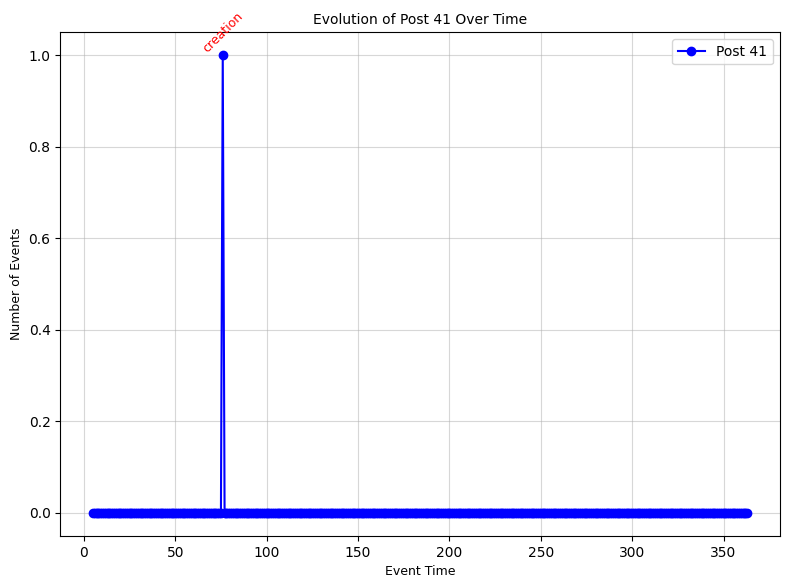

In [203]:
import numpy as np 

# Load the data
file_path = "post_evolution.csv"
df = pd.read_csv(file_path)

df["event_time"] = pd.to_numeric(df["event_time"], errors="coerce").fillna(0)
df = df[df['event_time'] >= df[df['event_type'] == 'creation']['event_time'].min()]

# Function to plot the evolution curve for a given post ID
def plot_post_evolution(post_id):
    # Filter events for the given post_id
    post_events = df[df["post_id"] == post_id]
    
    # Extract event times and create a time range from the start to the end of the simulation
    start_time = int(df["event_time"].min())
    end_time = int(df["event_time"].max())
    time_range = np.arange(start_time, end_time + 1)

    # Count events at each event_time for the given post
    event_counts = post_events.groupby("event_time").size()
    event_series = pd.Series(event_counts, index=event_counts.index)
    
    # Reindex to fill in missing times with 0
    event_series = event_series.reindex(time_range, fill_value=0)

    # Collect event types at each time point
    event_types = post_events.groupby("event_time")["event_type"].apply(list)
    
    # dict of rhe events type
    
    

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(event_series.index, event_series.values, marker="o", linestyle="-", color="blue", label=f"Post {post_id}")

    # Annotating the peaks with event types
    for time, count in event_series.items():
        if count > 0:  # Only annotate non-zero points
            types_at_time = ", ".join(event_types.get(time, [])) 
            plt.text(time, count, types_at_time, fontsize=9, ha="center", va="bottom", rotation=45, color="red")
    
    plt.title(f"Evolution of Post {post_id} Over Time", fontsize=10)
    plt.xlabel("Event Time", fontsize=9)
    plt.ylabel("Number of Events", fontsize=9)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_post_evolution(41) 


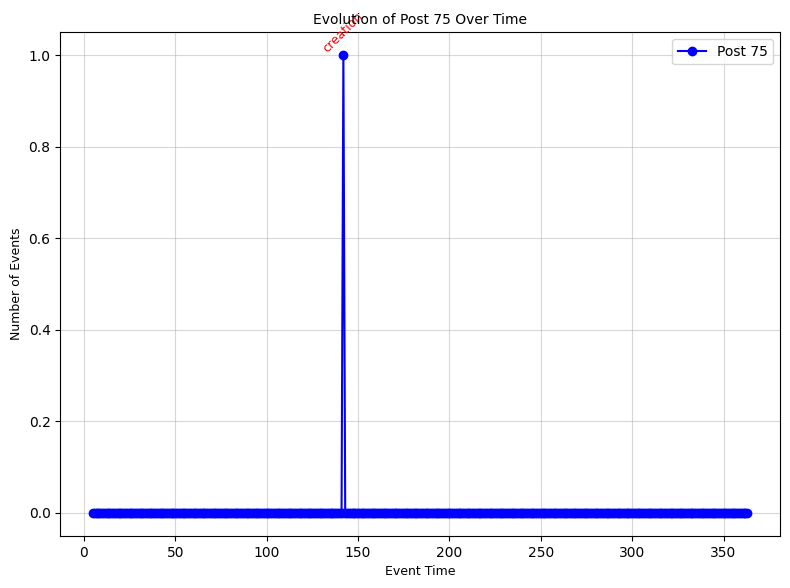

In [204]:
plot_post_evolution(75) 

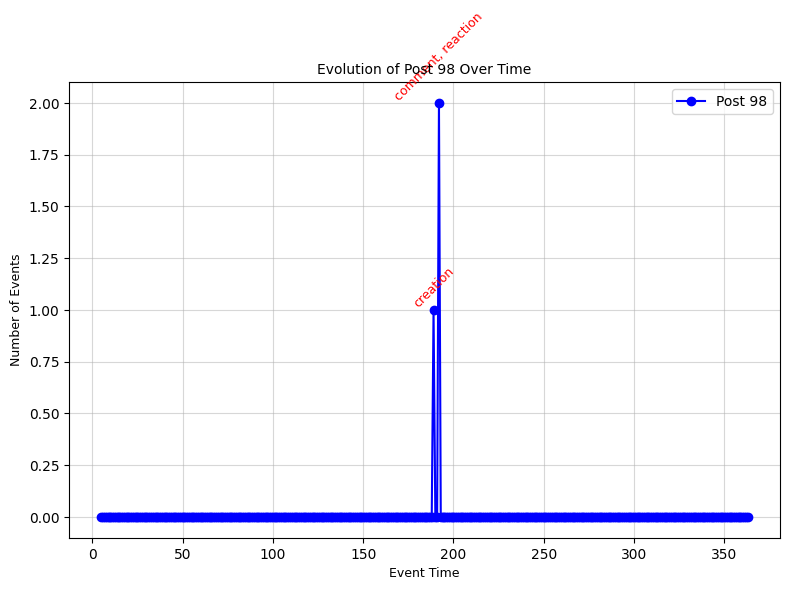

In [205]:
plot_post_evolution(98) 